In [ ]:
!pip install tensorflow
!pip install tensorflow.keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 865.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers



In [ ]:
# cargamos datos
df = pd.read_csv("datos_integrados.csv", parse_dates=["datetime"])


In [ ]:
# ========= 2) Separar por estación
estaciones = df["nombre"].unique()
df_por_estacion = {est: df[df["nombre"] == est].sort_values("datetime").copy() for est in estaciones}

In [ ]:
print(df_por_estacion.keys())

dict_keys(['ALGECIRAS EPS', 'JEREZ-CHAPMN', 'SAN FERNANDO'])


In [ ]:
# ============================
# LSTM vanilla horizon (6) + Permutation Importance por estación
# ============================

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def make_sequences_multi(X2d, y1d, lookback=72, horizon=6):
    """
    X2d: (T, F), y1d: (T,)
    -> X3d: (N, lookback, F), Y: (N, horizon)
    N = T - lookback - horizon + 1
    """
    T = len(X2d)
    N = T - lookback - horizon + 1
    if N <= 0:
        raise ValueError(f"No hay suficientes datos para lookback={lookback} y horizon={horizon} (T={T}).")
    Xs = np.empty((N, lookback, X2d.shape[1]), dtype=X2d.dtype)
    Ys = np.empty((N, horizon), dtype=y1d.dtype)
    for i in range(N):
        Xs[i] = X2d[i:i+lookback, :]
        Ys[i] = y1d[i+lookback : i+lookback+horizon]  # vector de H pasos
    return Xs, Ys

def build_lstm_vanilla_multi(n_features, lookback, horizon=6, lr=1e-3, units=64, drop=0.2):
    model = models.Sequential([
        layers.Input(shape=(lookback, n_features)),
        layers.LSTM(units),
        layers.Dropout(drop),
        layers.Dense(horizon)   # salida multi-paso
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mae")
    return model

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# ---------- Permutation Importance
def permutation_importance_lstm_multi(model,
                                      X_te_2d_s, y_te_1d_s,
                                      scaler_y, feature_names,
                                      lookback=72, horizon=6, horizon_idx=5,
                                      metric="mae", n_repeats=1,
                                      random_state=SEED):
    """
    Importancia por permutación sobre TEST para un paso concreto (horizon_idx).
    """
    rng = np.random.RandomState(random_state)

    # baseline (reconstruimos secuencias y evaluamos solo la columna horizon_idx)
    X_base_3d, Y_base_s = make_sequences_multi(X_te_2d_s, y_te_1d_s, lookback, horizon)
    Y_pred_base_s = model.predict(X_base_3d, verbose=0)
    y_pred_base   = scaler_y.inverse_transform(Y_pred_base_s)[:, horizon_idx]
    y_true        = scaler_y.inverse_transform(Y_base_s)[:, horizon_idx]

    if metric.lower() == "mae":
        base = mean_absolute_error(y_true, y_pred_base)
        scorer = lambda yt, yp: mean_absolute_error(yt, yp)
        label = "MAE"
    else:
        base = rmse(y_true, y_pred_base)
        scorer = lambda yt, yp: rmse(yt, yp)
        label = "RMSE"

    importances = []
    for j in range(X_te_2d_s.shape[1]):
        worse = []
        for _ in range(n_repeats):
            X_perm = X_te_2d_s.copy()
            rng.shuffle(X_perm[:, j])
            Xp_3d, Yp_s = make_sequences_multi(X_perm, y_te_1d_s, lookback, horizon)
            Y_pred_p_s = model.predict(Xp_3d, verbose=0)
            y_pred_p   = scaler_y.inverse_transform(Y_pred_p_s)[:, horizon_idx]
            y_true_p   = scaler_y.inverse_transform(Yp_s)[:, horizon_idx]
            worse.append(scorer(y_true_p, y_pred_p))
        importances.append(np.mean(worse) - base)

    imp_df = pd.DataFrame({
        "feature": feature_names,
        f"delta_{label}": importances
    }).sort_values(by=f"delta_{label}", ascending=False).reset_index(drop=True)

    return imp_df, label, base


# ---------- Entrenamiento + gráficos ----------
def train_lstm_station_vanilla_multi(df_estacion: pd.DataFrame,
                                     lookback=72, horizon=6, horizon_idx=5,
                                     epochs=60, batch_size=256,
                                     lr=1e-3, units=64, drop=0.2,
                                     plot_color="#1f77b4",
                                     save_csv=False, nombre_estacion="ESTACION"):
    """
    Entrena LSTM vanilla multi-salida (horizon=6) y evalúa/grafica el paso 'horizon_idx' (0..H-1).
    """
    d = df_estacion.sort_values("datetime").reset_index(drop=True).copy()

    # columnas sin lags/roll
    excluir = {"datetime","nombre","estacion","Latitude","Longitude"}
    cols = [c for c in d.columns if c not in excluir and "lag" not in c.lower() and "roll" not in c.lower()]
    cols = ["o3"] + [c for c in cols if c != "o3"]

    X_all = d[cols].astype(np.float32).values
    y_all = d["o3"].astype(np.float32).values

    # 70/10/20
    n = len(d)
    i_train, i_valid = int(n*0.7), int(n*0.8)
    X_tr, X_va, X_te = X_all[:i_train], X_all[i_train:i_valid], X_all[i_valid:]
    y_tr, y_va, y_te = y_all[:i_train], y_all[i_train:i_valid], y_all[i_valid:]
    fechas_test = d["datetime"].iloc[i_valid:]

    # escalado
    sx, sy = MinMaxScaler(), MinMaxScaler()
    X_tr_s, X_va_s, X_te_s = sx.fit_transform(X_tr), sx.transform(X_va), sx.transform(X_te)
    y_tr_s = sy.fit_transform(y_tr.reshape(-1,1)).ravel()
    y_va_s = sy.transform(y_va.reshape(-1,1)).ravel()
    y_te_s = sy.transform(y_te.reshape(-1,1)).ravel()

    # ventanas multi-salida
    X_tr_3d, Y_tr = make_sequences_multi(X_tr_s, y_tr_s, lookback, horizon)
    X_va_3d, Y_va = make_sequences_multi(X_va_s, y_va_s, lookback, horizon)
    X_te_3d, Y_te = make_sequences_multi(X_te_s, y_te_s, lookback, horizon)

    # fechas alineadas para el primer output futuro (= lookback+horizon-1)
    offset = lookback + horizon - 1
    fechas_test_alineadas = fechas_test.iloc[offset:]

    # modelo
    model = build_lstm_vanilla_multi(X_tr_3d.shape[2], lookback, horizon=horizon, lr=lr, units=units, drop=drop)
    es  = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)

    model.fit(X_tr_3d, Y_tr, validation_data=(X_va_3d, Y_va),
              epochs=epochs, batch_size=batch_size, callbacks=[es, rlr], verbose=1)

    # predicción y desescalado
    Y_pred_s = model.predict(X_te_3d, verbose=0)               # (N, H)
    Y_pred   = sy.inverse_transform(Y_pred_s)                  # desescala por columna
    Y_true   = sy.inverse_transform(Y_te)

    # métrica para el paso deseado
    y_pred_h = Y_pred[:, horizon_idx]
    y_true_h = Y_true[:, horizon_idx]
    mae_h    = mean_absolute_error(y_true_h, y_pred_h)
    rmse_h   = rmse(y_true_h, y_pred_h)
    print(f"[{nombre_estacion}] TEST (+{horizon_idx+1}h) -> RMSE={rmse_h:.2f}  MAE={mae_h:.2f}")

    # gráfico Real vs Predicción para ese paso
    plt.figure(figsize=(14,5))
    plt.plot(fechas_test_alineadas, y_true_h, label=f"Real (+{horizon_idx+1}h)", color="black", lw=0.7)
    plt.plot(fechas_test_alineadas, y_pred_h, label=f"Predicción LSTM (+{horizon_idx+1}h)", color=plot_color, lw=1.0)
    plt.title(f"O₃ - {nombre_estacion} (Real vs Predicción) - LSTM vanilla (h={horizon_idx+1}h)")
    plt.xlabel("Fecha"); plt.ylabel("O₃ (µg/m³)")
    plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

    if save_csv:
        out = pd.DataFrame({
            "datetime": fechas_test_alineadas.values,
            f"o3_real_h{horizon_idx+1}": y_true_h,
            f"o3_pred_h{horizon_idx+1}": y_pred_h
        })
        fname = f"pred_lstm_h{horizon_idx+1}_{nombre_estacion.replace(' ','_')}.csv"
        out.to_csv(fname, index=False)
        print(f"Guardado: {fname}")

    # permutation importance para ese paso
    imp_df, label, base = permutation_importance_lstm_multi(
        model, X_te_s, y_te_s, sy, cols,
        lookback=lookback, horizon=horizon, horizon_idx=horizon_idx,
        metric="mae", n_repeats=3, random_state=SEED
    )
    top = imp_df.head(12).iloc[::-1]
    plt.figure(figsize=(9,5))
    plt.barh(top["feature"], top[f"delta_{label}"], color=plot_color, alpha=0.85)
    for i, v in enumerate(top[f"delta_{label}"]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
    plt.xlabel(f"Aumento de {label} al permutar (baseline={base:.3f})")
    plt.title(f"Permutation Importance - {nombre_estacion} (+{horizon_idx+1}h)")
    plt.grid(axis='x', linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()

    return {
        "metrics": {"RMSE_h": rmse_h, "MAE_h": mae_h, "h": horizon_idx+1},
        "model": model,
        "importances": imp_df
    }

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1750 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0928 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0858 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0822 - val_loss: 0.1026 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0787 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0768 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0742 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0726 - val_loss: 0.0944 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0711 - val_loss: 0.0911 - learning_rate: 0.0010
E

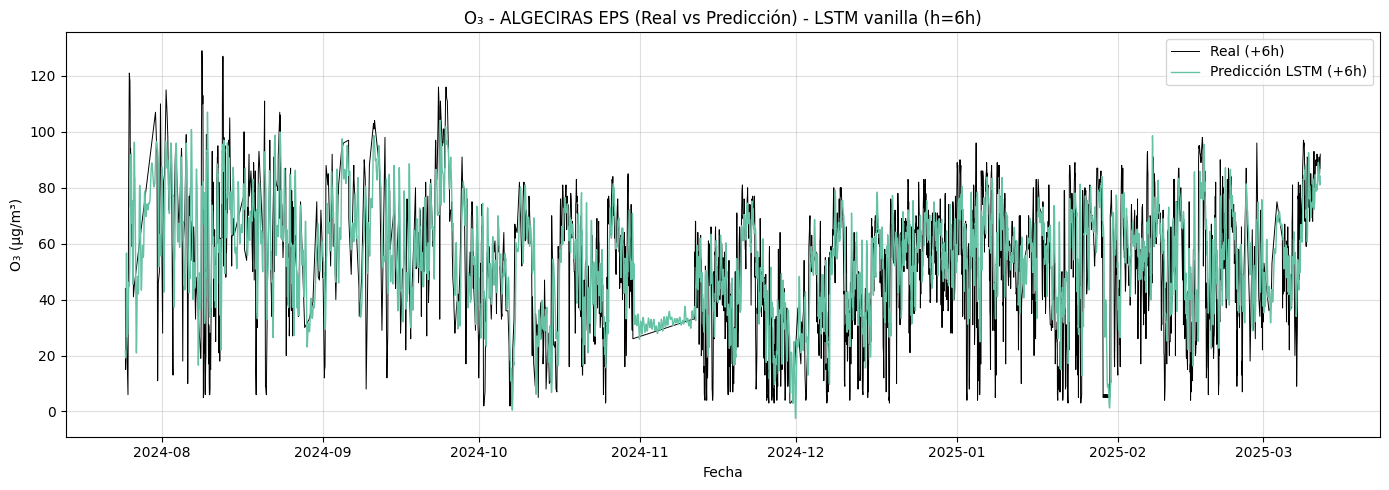

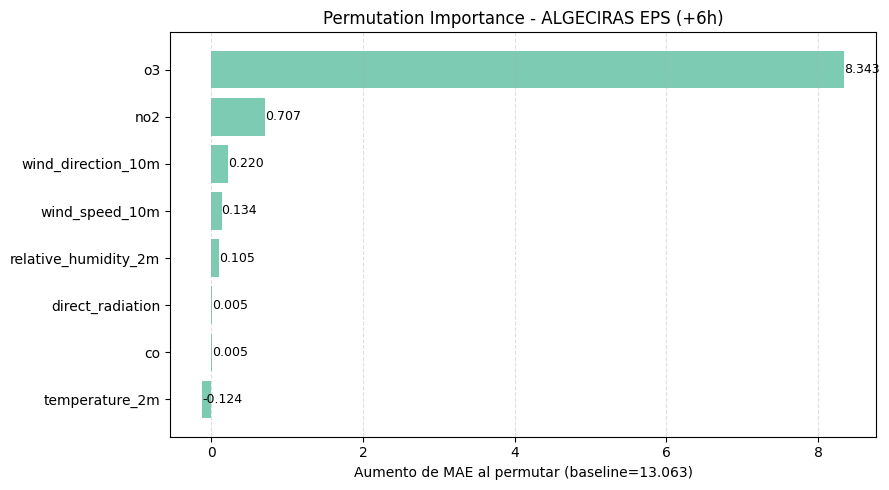

In [ ]:
salida = train_lstm_station_vanilla_multi(
    df_por_estacion["ALGECIRAS EPS"],
    lookback=72, horizon=6, horizon_idx=5,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#66c2a5",
    nombre_estacion="ALGECIRAS EPS"
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1848 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0766 - val_loss: 0.0659 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0691 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0644 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0602 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0555 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0527 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0503 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0484 - val_loss: 0.0518 - learning_rate: 0.0010
E

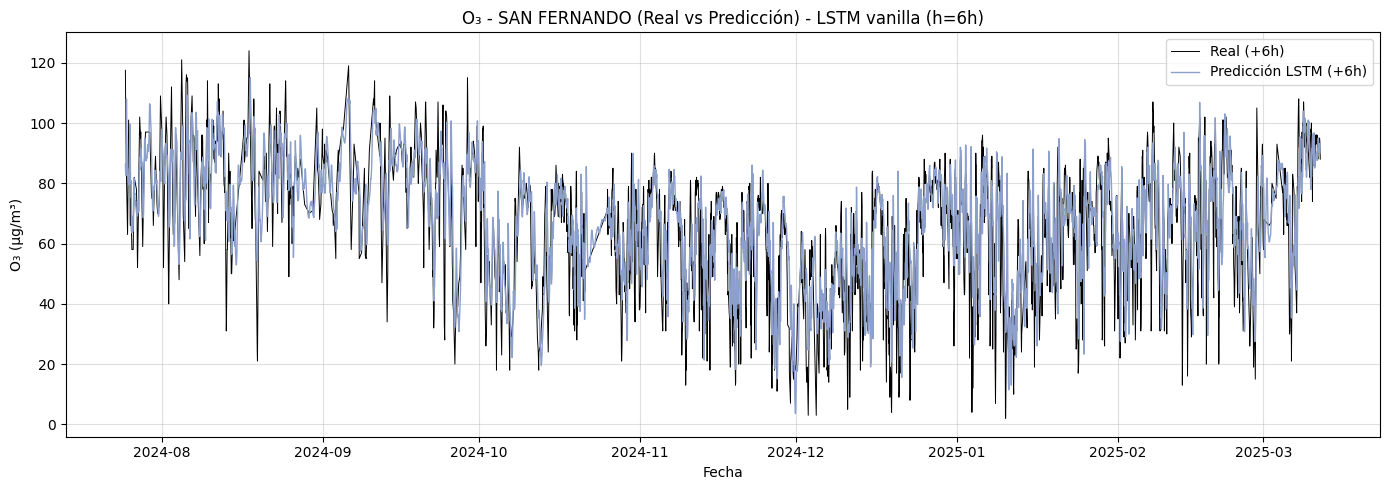

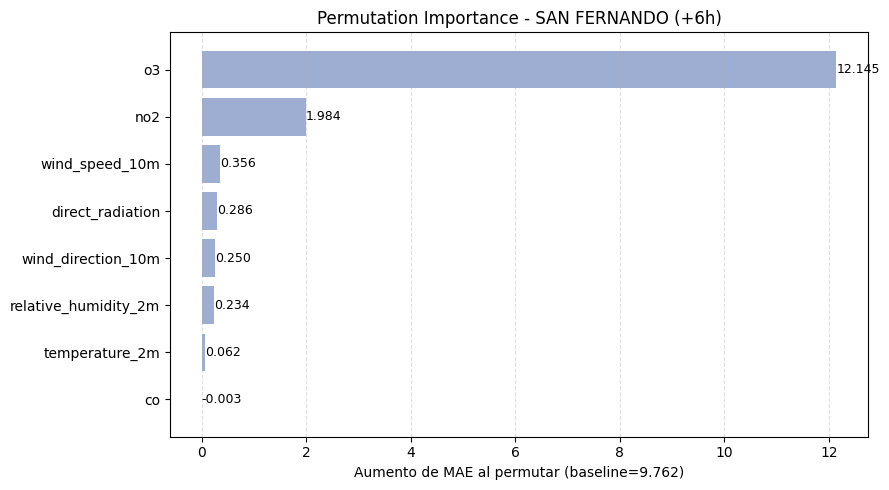

In [ ]:
salida = train_lstm_station_vanilla_multi(
    df_por_estacion["SAN FERNANDO"],
    lookback=72, horizon=6, horizon_idx=5,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#8da0cb",
    nombre_estacion="SAN FERNANDO"
)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1698 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0907 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0827 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0737 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0682 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0647 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0625 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0606 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0585 - val_loss: 0.0567 - learning_rate: 0.0010
E

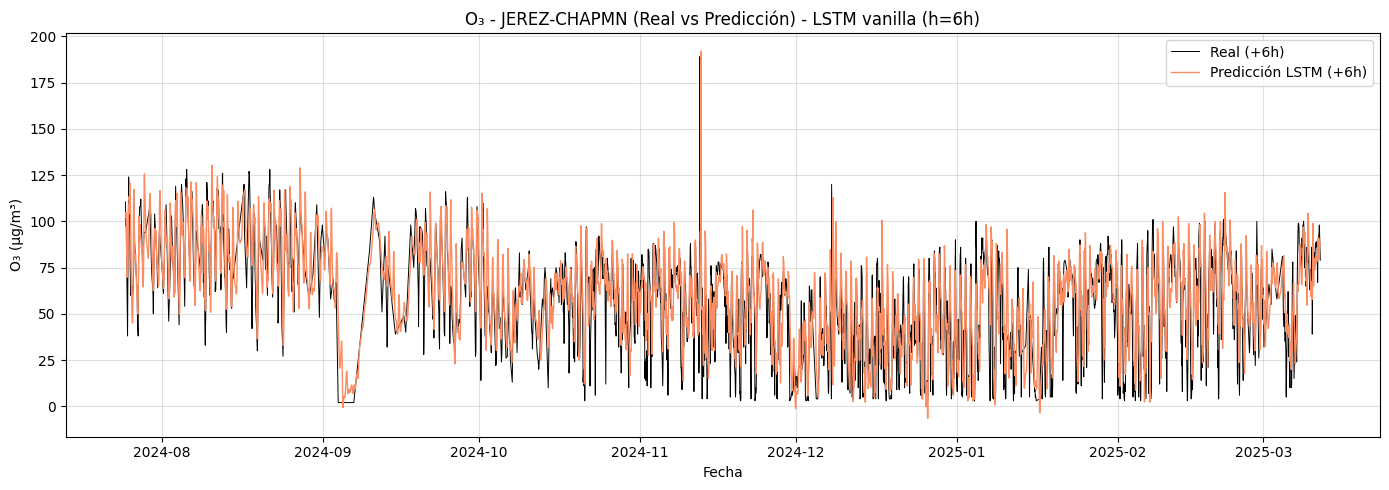

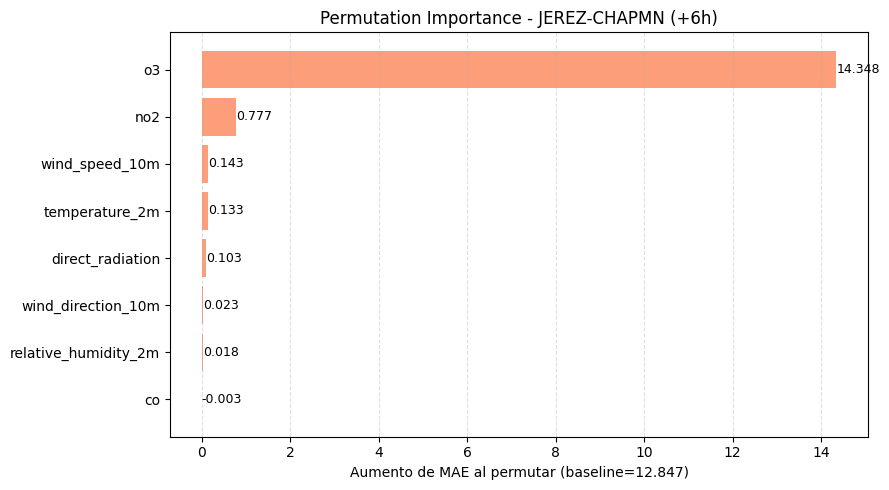

In [ ]:
salida = train_lstm_station_vanilla_multi(
    df_por_estacion["JEREZ-CHAPMN"],
    lookback=72, horizon=6, horizon_idx=5,
    epochs=50, batch_size=128,
    units=64, drop=0.2,
    plot_color="#fc8d62",
    nombre_estacion="JEREZ-CHAPMN"
)